# Exercise 1: OOP & Pandas Practice

### Combine the baby names by state data set into a single file using shell commands.

In [2]:
! mkdir -p ./dataset
! unzip babynamesbystate.zip -d ./dataset

Archive:  babynamesbystate.zip
   creating: ./dataset/babynamesbystate/
  inflating: ./dataset/__MACOSX/._babynamesbystate  
  inflating: ./dataset/babynamesbystate/IN.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._IN.TXT  
  inflating: ./dataset/babynamesbystate/IL.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._IL.TXT  
  inflating: ./dataset/babynamesbystate/KS.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._KS.TXT  
  inflating: ./dataset/babynamesbystate/SC.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._SC.TXT  
  inflating: ./dataset/babynamesbystate/HI.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._HI.TXT  
  inflating: ./dataset/babynamesbystate/GA.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._GA.TXT  
  inflating: ./dataset/babynamesbystate/SD.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._SD.TXT  
  inflating: ./dataset/babynamesbystate/CO.TXT  
  inflating: ./dataset/__MACOSX/babynamesbystate/._CO.TXT  
  i

In [3]:
! cat ./dataset/babynamesbystate/*.TXT >> ./dataset/mergedData.TXT
#! tail -f ./dataset/mergedData.TXT & 

### 1. Create a class called BabyNames

for popularity, shall we consider those names which are present in 1 year and not present in 2nd year ?

In [16]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from IPython.display import display, HTML

class BabyNames(object):
    def __init__(self, dataset_path):
        """
        1.a
        args:
            dataset_path : path of dataset text file 
        """
        column_names = ["StateCode","Sex","BirthYear","CharacterName","NumOccurences"]
        self.dataset = pd.read_csv(dataset_path, quotechar='"', sep=',', header=None, names=column_names)
        self.dataset = self.dataset.astype({"BirthYear": str, "NumOccurences": int})
    
    def get_state_year_df(self, state, year):
        """
        Helper function to filter out dataset based on given state and year
        args:
            state : name of the state on which data is to be filtered. If empty, then not considered
            year : year on which data is to be filtered. If empty, then not considered
        output:
            df : filtered dataframe
        """
        # If both state and year are non-empty, then use both as filtering param
        if len(state) > 0 and len(year) > 0:
            df = self.dataset[(self.dataset.StateCode == state) & (self.dataset.BirthYear == year)]
        # If state is empty and year is non-empty, use year as filtering param
        elif len(state) == 0 and len(year) > 0:
            df = self.dataset[self.dataset.BirthYear == year]
        # If state is non-empty and year is empty, use state as filtering param
        elif len(state) > 0 and len(year) == 0:
            df = self.dataset[self.dataset.StateCode == state]
        # If both are empty, then return entire dataframe
        else:
            df = self.dataset
        return df
    
    def count(self, state='', year=''):
        """
        1.b
        Returns birth count for a given state in a given year
        args:
            state : name of the state
            year : year 
        output:
            total_birth_count : Number of births in given state and year
        """
        # Filtering the data based on state and year
        state_year_df = self.get_state_year_df(state, year)
        # Counting birth count from the filtered dataframe
        total_birth_count = state_year_df['NumOccurences'].sum()
        return total_birth_count

    def top10babynames(self, state='', year=''):
        """
        1.c
        Rank top 10 male and female for a given state and year
        Criterion for Ranking:
            - Ranking is done based on the Number of occurence of a particular name
            - Name with highest freqency is ranked 1 
        args:
            state: name of the state
            year : year 
        returns:
            result_df: dataframe containing ranked baby names
        """
        topK = 10
        # Filtering the data based on state and year
        state_year_df = self.get_state_year_df(state, year)
        # Finding top 10 highest frequent males from the filtered dataframe
        male_baby_list = (state_year_df[state_year_df.Sex == 'M']
                          .groupby('CharacterName')
                         .sum()
                         .reset_index()
                         .sort_values(by=['NumOccurences'], ascending=False)
                         .iloc[:topK].CharacterName.tolist())
        # Finding top 10 highest frequent females from the filtered dataframe
        female_baby_list = (state_year_df[state_year_df.Sex == 'F']
                         .groupby('CharacterName')
                         .sum()
                         .reset_index()
                         .sort_values(by=['NumOccurences'], ascending=False)
                         .iloc[:topK].CharacterName.tolist())
        # Assigning Rank from 1 to 10. Highest Frequency Baby has rank 1 and so on.
        rank_list = list(range(1, topK+1))
        result_df = pd.DataFrame({
            "Rank" : rank_list,
            "Male" : male_baby_list,
            "Female" : female_baby_list
        })
        return result_df
            
    def change_of_popularity(self, fromYear, toYear, top=10):
        """
        1.d
        Method list out the baby names which shows the below popularity trends from "fromYear" to "toYear"
            - increasing popularity
            - decreasing popularity
            - Equal popularity
            
        Criterion for calculating change in popularity
            let freqA be the frequency of a name in "fromYear"
            let freqB be the frequency of a nmae in "toYear"
                - freqB > freqA ==> Increasing Popularity
                - freqB < freqA ==> Decreasing Popularity
                - freqB = freqA ==> Equal Popularity
        
        Here I have not considered the filtering based on Gender.
        This means if nameA has both Male and Female, I have considered it just as a single name.
        
        args:
            fromYear: start year
            toYear: end year
            top: number of entries to return 
        returns:
            result_df: dataframe containing baby names and their change in popularity count
        """
        # Filtering the dataset based on fromYear BirtYear and creating a name to frequency dictionary
        dfA = self.dataset[self.dataset.BirthYear == fromYear].groupby('CharacterName')['NumOccurences'].sum().to_dict()
        # Filtering the dataset based on toYear BirtYear and creating a name to frequency dictionary
        dfB = self.dataset[self.dataset.BirthYear == toYear].groupby('CharacterName')['NumOccurences'].sum().to_dict()
        
        unique_names = self.dataset.CharacterName.unique().tolist()
        posPop = {}
        negPop = {}
        equalPop = {}
        # Traversing through each unique name and calculating the popularity
        # If a dictionary does not contain a particular name, then freq is 0
        for name in unique_names:
            freqA = dfA.get(name, 0)
            freqB = dfB.get(name, 0)
            
            if freqB > freqA:
                # Increase Popularity
                posPop[name] = freqB - freqA
            elif freqA > freqB:
                # Decreasing Popularity
                negPop[name] = abs(freqB - freqA)
            else:
                # Equal Popularity
                equalPop[name] = freqA
        df_posPop = pd.DataFrame({"Name" : posPop.keys(), "Pop": posPop.values()})
        df_negPop = pd.DataFrame({"Name" : negPop.keys(), "Pop": negPop.values()})
        df_equalPop = pd.DataFrame({"Name" : equalPop.keys(), "Pop": equalPop.values()})
        
        # Sorting all the popularity dataframes based on Popularity first (Desc), then Name (Asc)
        df_posPop = df_posPop.sort_values(by=['Pop','Name'], ascending=[False, True]).iloc[:top]
        df_negPop = df_negPop.sort_values(by=['Pop', 'Name'], ascending=[False, True]).iloc[:top]
        df_equalPop = df_equalPop.sort_values(by=['Pop','Name'], ascending=[False,True]).iloc[:top]
        
        result_df = pd.DataFrame({
            "increasing_popularity" : df_posPop.Name.tolist(),
            "increasing_popuarity_count" : df_posPop.Pop.tolist(),
            "decreasing_popularity" : df_negPop.Name.tolist(),
            "decreasing_popularity_count" : df_negPop.Pop.tolist(),
            "equal_popularity" : df_equalPop.Name.tolist(),
            "equal_popularity_count" : df_equalPop.Pop.tolist()
        })

        return result_df
    
    def top5_names_per_year(self, year, sex=''):
        """
        1.e
        Given year and gender of a baby, the method computes the top 5 ranked names for all the states
        
        Criterion for ranking
            - Number of Occurences of a particular name. Highest freq name is ranked 1
            - After number of occurences, Name and Sex is considered in Ascending order
        
        args:
            year : Year of the birth
            sex  : Gender of a baby
        returns:
            result_df : dataframe with state and babies with top 5 ranks
        """
        assert year is not None or len(year) > 0, f"year is a mandatory field"
        
        topk = 5
        if len(sex) == 0:
            # If Gender is not provided, consider Year to filter only
            filter_df = self.dataset[(self.dataset.BirthYear == year)]
        else:
            # use year and sex both, if both are non-empty
            filter_df = self.dataset[(self.dataset.BirthYear == year) & (self.dataset.Sex == sex)]
         
        filter_df = filter_df.groupby('StateCode')
        row_list = []
        for state, state_df in filter_df:
            # Sorting state filtered dataframe based on name frequency(DESC), Name(ASC) and SEX(ASC)
            state_df = state_df.sort_values(by=['NumOccurences','CharacterName','Sex'], ascending=[False, True, True]).iloc[:topk]
            curr_row = []
            curr_row.append(state)
            for idx, row in enumerate(state_df.itertuples()):
                curr_row.append(row.CharacterName)
                curr_row.append(row.NumOccurences)
            
            row_list.append(curr_row)
        
        result_df = pd.DataFrame(row_list, columns=['State', 'Rank 1', 'Num 1',
                                          'Rank 2', 'Num 2', 'Rank 3',
                                          'Num 3', 'Rank 4', 'Num 4',
                                          'Rank 5', 'Num 5'])
        return result_df
     
    def name_popularity_plot(self, name, yearRange, state, sex):
        """
        1.f) 
        Given babyname, gender, state and a year range, the method generates a plot showing the trends of the 
        name in that state.
        
        As per Question: Popularity is proportional to Freq(Name) / Sum of total occurences of all names
        
        Since Denominator will be constant for all, here we are using Freq(Name) as the popularity measure
        args:
            name : name of the baby 
            yearRange : tuple of start year and end year
            state : state of the birth of baby 
            year : year of birth
        """
        startYear = int(yearRange[0])
        endYear = int(yearRange[1])
        
        popularity_list = []
        # Iterating over all the years in the year range
        for year in range(startYear, endYear+1):
            # For a given year, filter out the data of the given state
            state_year_df = self.dataset[(self.dataset.BirthYear == str(year)) & (self.dataset.StateCode == state)]
            # Calculating Freq of a given name based on Gender provided
            person_occ = state_year_df[(state_year_df.CharacterName==name) & (state_year_df.Sex==sex)]['NumOccurences']
            if person_occ.shape[0] == 0:
                person_occ = 0
            else:
                person_occ = int(person_occ.iloc[0])
            person_pop = person_occ 
            popularity_list.append(person_pop)
        
        # Plotting the popularity trend
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        ax.plot(list(range(startYear, endYear+1)),popularity_list)
        ax.set_xlabel('Year')
        ax.set_ylabel('Popularity in %')
        ax.set_title(f"Popularity Trend Chart for {name}/{sex} from Year {startYear} to {endYear} in the state of {state}" )
        ax.grid()
        plt.show()
    
    def name_flip(self, n):
        """
        1.g
        Solution Logic: 
            Plot freq(Name,M) / freq(Name,M) + freq(Name,F) over the years
            If the plot intersects each other, then there is a flip of gender from M -> F or F -> M            
        """        
        df = self.dataset.copy()
        
        # Creating Separate dataframes for Male and Female with Name and Total Freq of each name
        df_male = df[df.Sex=='M'].groupby('CharacterName')['NumOccurences'].sum().reset_index()
        df_female = df[df.Sex=='F'].groupby('CharacterName')['NumOccurences'].sum().reset_index()
        
        # Finding common names from male and female, as they can only flip
        df_common = pd.merge(df_male, df_female, on='CharacterName', suffixes=('_male','_female'), how='inner')
        common_names = df_common.CharacterName.unique().tolist()

        # Creating a filtered data from the master df based on common names
        df_filtered = df[df.CharacterName.isin(common_names)]

        flipped_names_list = []

        for count,name in enumerate(common_names):
            # Getting the name df and summing the freq of the name for each Year and Sex
            df_name  = df_filtered[df_filtered.CharacterName == name].groupby(['BirthYear', 'Sex'])['NumOccurences'].sum().reset_index()

            # If name is male first and then flipped to female
            if (int(df_name[df_name.Sex == 'M'].BirthYear.iloc[0]) < int(df_name[df_name.Sex == 'F'].BirthYear.iloc[0])) & \
            (df_name[df_name.Sex == 'F'].NumOccurences.sum() > df_name[df_name.Sex == 'M'].NumOccurences.sum()):
                flipped_names_list.append(name)
            # If name is female first and then flipped to male
            elif (int(df_name[df_name.Sex == 'M'].BirthYear.iloc[0]) > int(df_name[df_name.Sex == 'F'].BirthYear.iloc[0])) & \
                (df_name[df_name.Sex == 'F'].NumOccurences.sum() < df_name[df_name.Sex == 'M'].NumOccurences.sum()):
                flipped_names_list.append(name)

            total = len(common_names)
            if (count+1) % 100 == 0:
                print(f"{count+1}/{total} Done")
        
        # Finding top n names from the flipped names based on the total freq of the name
        tmp_count_df = df_filtered[df_filtered.CharacterName.isin(flipped_names_list)].groupby('CharacterName')['NumOccurences'].sum().reset_index().sort_values(by=['NumOccurences', 'CharacterName'], ascending=[False,True])
        top_n_names = tmp_count_df.head(n)['CharacterName'].tolist()

        df_flip = df_filtered[df_filtered.CharacterName.isin(top_n_names)]

        num_cols = 3
        num_rows = (n // num_cols) + (n % num_cols)

        plt.figure(figsize=(20, 15))

        # Plotting the trends of flip for each top n name
        for count, name in enumerate(top_n_names):
            # Getting male and female data for a particular name and their total freq for each year
            male_count_df = df_flip[(df_flip.CharacterName == name) & (df_flip.Sex == 'M')].groupby(['BirthYear'])['NumOccurences'].sum().reset_index()
            female_count_df = df_flip[(df_flip.CharacterName == name) & (df_flip.Sex == 'F')].groupby(['BirthYear'])['NumOccurences'].sum().reset_index()
            
            # Combining both male and female df on birthyear and replacing null values with 0
            combined_count_df = pd.merge(male_count_df, female_count_df, on='BirthYear', how='outer', suffixes=('_male','_female')).fillna(0)
            
            # Calculating the male and female ratio to be plotted
            combined_count_df['male_ratio'] = combined_count_df.NumOccurences_male / \
            (combined_count_df.NumOccurences_male + combined_count_df.NumOccurences_female )
            combined_count_df['female_ratio'] = combined_count_df.NumOccurences_female / \
            (combined_count_df.NumOccurences_male + combined_count_df.NumOccurences_female )

            combined_count_df = combined_count_df.sort_values('BirthYear')

            birth_year_list = combined_count_df['BirthYear'].unique().tolist()
            indices = np.linspace(0, len(birth_year_list) - 1, 5, dtype=int)
            selected_x_ticks = [birth_year_list[i] for i in indices]

            plt.subplot(num_rows, num_cols, count+1)  
            plt.plot(combined_count_df['BirthYear'],combined_count_df['male_ratio'], label='Male Ratio',color='blue')
            plt.plot(combined_count_df['BirthYear'],combined_count_df['female_ratio'], label='Female Ratio',color='red')
            plt.legend()
            plt.xticks(selected_x_ticks)
            plt.title(f"Gender Count trend of name = {name}")
        plt.show()
        return top_n_names
        

### 1.a

In [17]:
babyName = BabyNames(dataset_path = './dataset/mergedData.TXT')

### 1.b

In [31]:
STATE = 'CA'
YEAR = '2000'
babyCount = babyName.count(state = STATE , year = YEAR)
print(f"Baby Count for State = {STATE} in year = {YEAR} : {babyCount}")

Baby Count for State = CA in year = 2000 : 471610


### 1.c

In [32]:
STATE = ''
YEAR = ''
top10baby = babyName.top10babynames(state = STATE, year = YEAR)
top10baby

,Rank,Male,Female
0,1,James,Mary
1,2,John,Patricia
2,3,Robert,Elizabeth
3,4,Michael,Jennifer
4,5,William,Linda
5,6,David,Barbara
6,7,Richard,Margaret
7,8,Joseph,Susan
8,9,Charles,Dorothy
9,10,Thomas,Jessica


### 1.d

In [33]:
from_year = '2014'
to_year = '2015'
topk = 10
df_pop_change = babyName.change_of_popularity(fromYear=from_year, toYear=to_year, top=topk)
df_pop_change

,increasing_popularity,increasing_popuarity_count,decreasing_popularity,decreasing_popularity_count,equal_popularity,equal_popularity_count
0,Oliver,2217,Jayden,1562,Danny,688
1,Alexa,1793,Isabella,1472,Rosa,418
2,Mia,1397,Jase,1453,Hadassah,358
3,Hazel,1396,Sophia,1201,Lara,285
4,Grayson,1357,Joshua,1102,Yousef,256
5,Matteo,1356,Annabelle,1084,Azaria,239
6,Charlotte,1287,Andrew,1049,Abdiel,201
7,Mateo,1277,Peyton,1020,Reuben,198
8,Lincoln,1205,Michael,1012,Kymani,184
9,Scarlett,1127,Alexis,1006,Abner,141


### 1.e

In [34]:
YEAR = '2013'
SEX = 'M'

display_gender = 'Male' if SEX == 'M' else 'Female'
df_top5_names = babyName.top5_names_per_year(year='2013', sex='M')

# Convert DataFrame to HTML
df_html = df_top5_names.to_html(index=False, border=0)

# Create the title and the table within a centered div
combined_html = """
<div style="margin:auto; width:50%;">
    <h4 style="text-align:center;">Top Five {0} Names for Births in {1}</h4>
    {2}
</div>
""".format(display_gender,YEAR,df_html)

display(HTML(combined_html))

State,Rank 1,Num 1,Rank 2,Num 2,Rank 3,Num 3,Rank 4,Num 4,Rank 5,Num 5
AK,Liam,64,William,49,Mason,47,Noah,46,Wyatt,46
AL,William,438,Mason,293,James,288,John,281,Elijah,247
AR,William,196,Mason,187,Noah,161,James,147,Elijah,138
AZ,Jacob,389,Noah,389,Liam,388,Alexander,370,Daniel,362
CA,Jacob,2890,Ethan,2667,Daniel,2603,Jayden,2581,Matthew,2565
CO,Liam,350,Noah,309,Jackson,269,Alexander,262,William,258
CT,William,208,Mason,198,Jacob,193,Noah,192,Michael,187
DC,William,87,Alexander,77,John,70,Henry,69,Samuel,61
DE,Michael,62,Mason,60,Liam,58,Aiden,51,William,50
FL,Jayden,1126,Jacob,1099,Liam,1074,Noah,1050,Michael,987


### 1.f

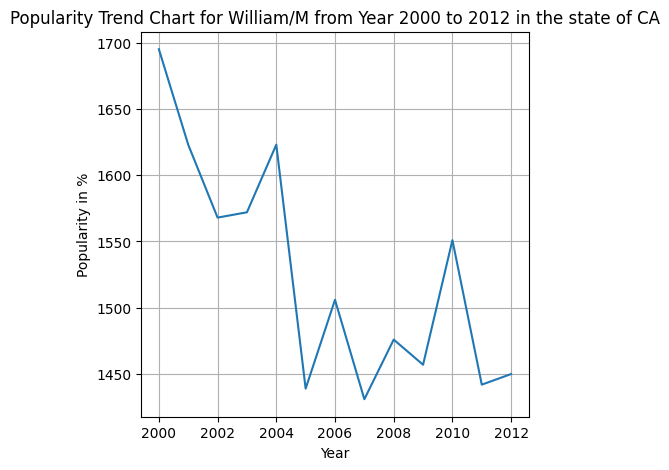

In [36]:
BabyName = 'William'
year_range = ('2000','2012')
State = 'CA'
Sex = 'M'

babyName.name_popularity_plot(name=BabyName, yearRange=year_range, state=State,sex=Sex)

### 1.g

  StateCode Sex BirthYear CharacterName  NumOccurences
0        AK   F      1910          Mary             14
1        AK   F      1910         Annie             12
2        AK   F      1910          Anna             10
3        AK   F      1910      Margaret              8
4        AK   F      1910         Helen              7
100/3126 Done
200/3126 Done
300/3126 Done
400/3126 Done
500/3126 Done
600/3126 Done
700/3126 Done
800/3126 Done
900/3126 Done
1000/3126 Done
1100/3126 Done
1200/3126 Done
1300/3126 Done
1400/3126 Done
1500/3126 Done
1600/3126 Done
1700/3126 Done
1800/3126 Done
1900/3126 Done
2000/3126 Done
2100/3126 Done
2200/3126 Done
2300/3126 Done
2400/3126 Done
2500/3126 Done
2600/3126 Done
2700/3126 Done
2800/3126 Done
2900/3126 Done
3000/3126 Done
3100/3126 Done
Ashley
Terry
Lauren
Taylor
Alexis
Madison
Shannon
Tracy
Allison
Morgan


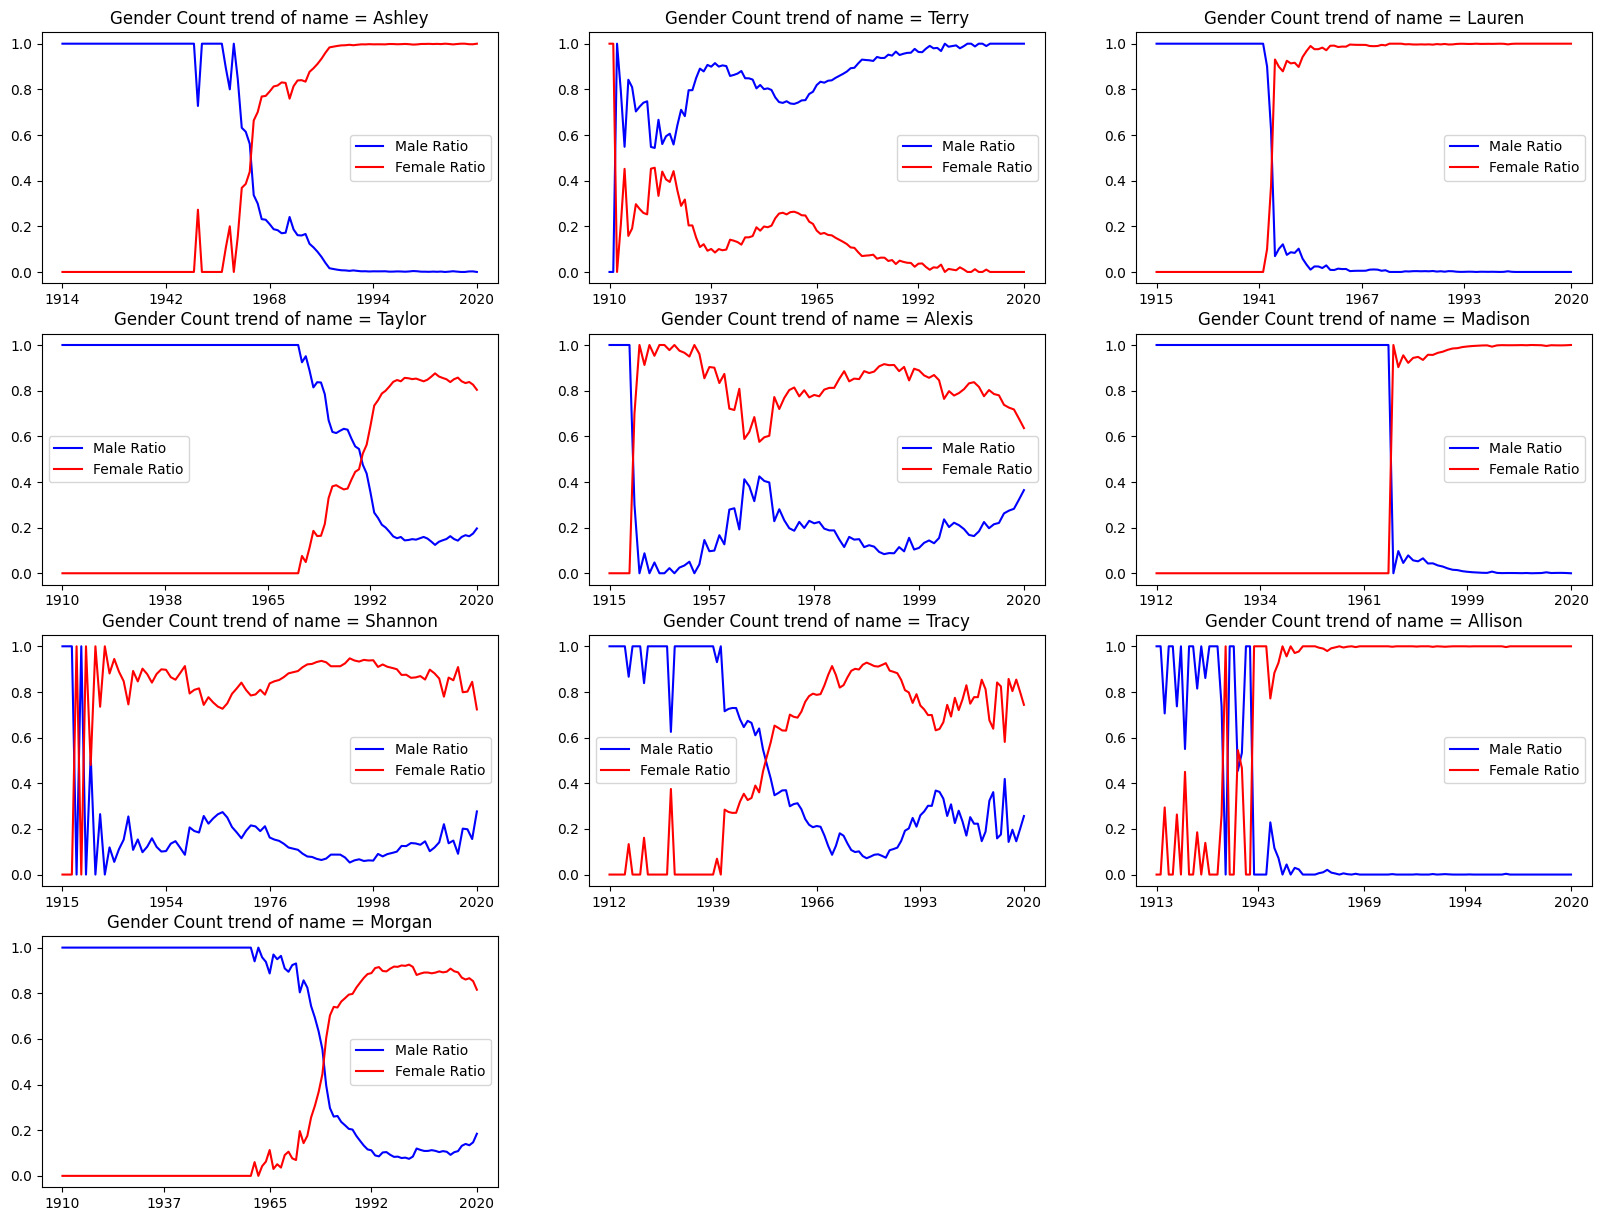

['Ashley', 'Terry', 'Lauren', 'Taylor', 'Alexis', 'Madison', 'Shannon', 'Tracy', 'Allison', 'Morgan']


In [19]:
top_n_flipped_names = babyName.name_flip(n=10)
print(top_n_flipped_names)

### Exercise 2: Statistics & Data Visualizaiton Practice 

#### In a given course the following applies (the data set exams.csv file is attached):
* The system tracks students by student name and unique ID.
* Grades are based on:
    * Exams Score (40% of the final grade)
    * Projects Score (30% of the final grade)
    * Quizzes Score (30% of the final grade)
* Final Grades are based on the final score (out of 100) as follows:
    * [90-100]: A
    * [80-90): B
    * [20-80): C
    * [10-20): D
    * [0-10): F
    
    
### 1. Load the exams.csv file into a DataFrame.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Read in exams.csv as pandas DataFrame
exams = pd.read_csv("exams.csv")
exams.head()

,id,Name,Quizzes,Projects,Exams
0,ID1,James,43,51,55
1,ID2,Josephine,76,84,87
2,ID3,Art,89,94,92
3,ID4,Lenna,70,67,64
4,ID5,Donette,63,59,58


### 2. Identify outlier students, or those who have final scores that are outside of the mean +/- two standard deviations of the final scores.

In [3]:
# Calculate final scores based on grade weights
exams['Final_Score'] = 0.4*exams['Exams'] + 0.3*exams['Projects'] + 0.3*exams['Quizzes']

# Calculate the mean and standard deviation of final_score
mean_final_grade = st.mean(exams['Final_Score'])
sd_final_grade = st.stdev(exams['Final_Score'])

# Calculate mean +/- 2*sd using the mean_final_grade and sd_final_grade
upper = mean_final_grade + (2*sd_final_grade)
lower = mean_final_grade - (2*sd_final_grade)

# Find all instances of Final_Scores below the lower bound and scores 
# Above upper bound. These represent all scores outside mean +/- 2sd of final_scores
exams.loc[(exams['Final_Score'] < lower) | (exams['Final_Score'] > upper)]




,id,Name,Quizzes,Projects,Exams,Final_Score
6,ID7,Mitsue,41,43,34,38.8
33,ID34,Albina,21,41,33,31.8
41,ID42,Dyan,99,100,100,99.7
45,ID46,Fatima,93,100,100,97.9
60,ID61,Blondell,37,28,32,32.3


### 3. Create box plot parameters (not drawing them, but just computing the numbers,  min, max, median, Q1 and Q3 for a box plot).

In [7]:
# Caulcuate min and max final_score
min_grade = min(exams['Final_Score'])
max_grade = max(exams['Final_Score'])

# Use numpy package to calculate median,q1,q3
med_grade = np.median(exams['Final_Score'])
q1_grade = np.percentile(exams['Final_Score'], 25)
q3_grade = np.percentile(exams['Final_Score'], 75)

print(min_grade, q1_grade, med_grade, q3_grade, max_grade)

31.8 60.324999999999996 68.65 80.25 99.7


### 4. Create a seaborn visualization that shows the final letter grades distribution. Choose the visualization that you think best represents the data. Explain your reasoning.

In [9]:
# Create list of boolean values to convert final_score to letter_grade
letter_grades = [
    (exams['Final_Score'] >= 90) ,
    (exams['Final_Score'] >= 80) & (exams['Final_Score'] <= 89),
    (exams['Final_Score'] >= 20) & (exams['Final_Score'] <= 79),
    (exams['Final_Score'] >= 10) & (exams['Final_Score'] <= 19),
    (exams['Final_Score'] < 10)
]
# create column headers for grades
results = ['A', 'B', 'C', 'D', 'F']

# Create new column for Letter_Grade using np.select()
exams['Letter_Grade'] = np.select(letter_grades, results)
exams.head()

,id,Name,Quizzes,Projects,Exams,Final_Score,Letter_Grade
0,ID1,James,43,51,55,50.2,C
1,ID2,Josephine,76,84,87,82.8,B
2,ID3,Art,89,94,92,91.7,A
3,ID4,Lenna,70,67,64,66.7,C
4,ID5,Donette,63,59,58,59.8,C


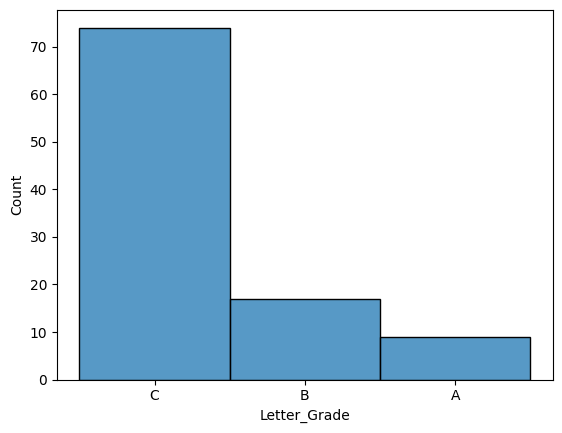

In [19]:
# Create seaborn histogram of letter_grade distribution
sns.histplot(exams['Letter_Grade']);

A histogram is the best choice to represent the distribution of letter grades because it clearly shows how many of each letter_grades are present. From the visualization it is clear that the majority of students ended the class with a 'C' grade. The visualization also makes it clear that there are no students who recieved a grade of 'D' or 'F'. 

### 5. Discover two more insights from the data. Support your insights with calculations and/or seaborn plots.

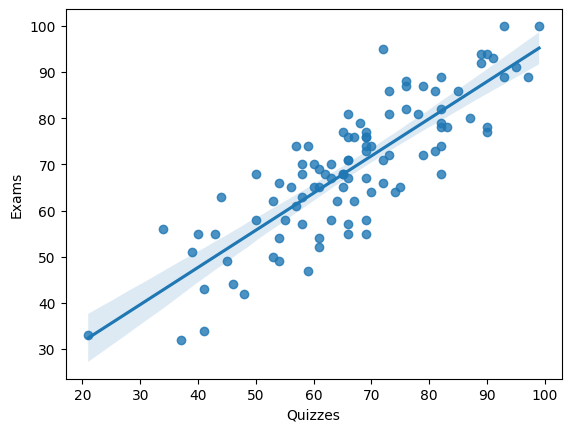

In [25]:
sns.regplot(data=exams, x="Quizzes", y="Exams");

This visualization helps determine if there a relationship with Quiz Grades and Exam Grades. From this plot we can see that there is a clear positive linear relationship between the two grades, meaning as quiz grades increase, so does exam grades. 

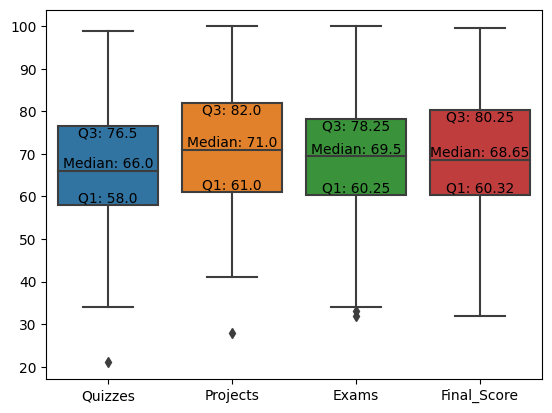

In [35]:
exams = exams[['Quizzes', 'Projects', 'Exams', 'Final_Score']]
ax = sns.boxplot(data=exams);

# Annotate boxplot values
for i, column in enumerate(exams.columns):
    box_data = exams[column]
    median = box_data.median()
    q1 = round(box_data.quantile(0.25),2)
    q3 = round(box_data.quantile(0.75),2)

    # Annotate median
    ax.text(i, median, f'Median: {median}', ha='center', va='bottom', color='black')

    # Annotate quartiles
    ax.text(i, q1, f'Q1: {q1}', ha='center', va='bottom', color='black')
    ax.text(i, q3, f'Q3: {q3}', ha='center', va='top', color='black')

This visualization helps us see the distribution of each score type. For example, we can see that quizzes has the lowest score out of all scores. Quizzes, Projects, and Exams all contain outliers on the bottom end of the grade distributions. Projects has the highest q1,median, and q3 values across all categories. The distribution of the Exams and Final Scores appear to be the most simliar. 